# Allenamento baseline ResNet50 per Traslazione + Rotazione (Pose Estimation)

Questo notebook permette di:
1. **Import e Setup**
2. **Carica dataset LineMOD**
3. **Inizializza PoseEstimator** (ResNet-50 backbone)
4. **Training**
5. **Valutazione su test set**

## 1. Import e Setup

In [ ]:
import sys
from pathlib import Path
import torch
from torch import optim
import yaml
from pathlib import Path
import random
import numpy as np
import pandas as pd

# Importa il config per usare path e file in altre cartelle
sys.path.insert(0, str(Path.cwd().parent))  # Aggiungi parent al path
from config import Config
from models.pose_estimator_endtoend import PoseEstimator
from utils.losses import PoseLoss
from dataset.linemod_pose import create_pose_dataloaders
from utils.visualization import plot_training_validation_loss_from_csv, show_pose_samples_with_add, plot_add_per_class
from utils.training import train_pose_full
from utils.transforms import quaternion_to_rotation_matrix_batch
from utils.metrics import compute_add_batch_full_pose
from utils.file_io import load_all_models, load_models_info
from utils.validation import run_deep_pose_pipeline


## 2. Carica dataset LineMOD

In [2]:
# Carica i dataloader train, val e test
train_loader, val_loader, test_loader = create_pose_dataloaders(
    dataset_root=Config.LINEMOD_ROOT,
    batch_size=Config.POSE_BATCH_SIZE,
    crop_margin=Config.POSE_CROP_MARGIN,
    output_size=Config.POSE_IMAGE_SIZE,
    num_workers=Config.NUM_WORKERS
)

print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)} | Test batches: {len(test_loader)}")

Train batches: 30 | Val batches: 8 | Test batches: 210


## 3. Inizializza Modello PoseEstimatorBaseline

In [4]:
# Inizializza il modello end-to-end per rotazione + traslazione (ResNet-50)
model = PoseEstimator(
    pretrained=True,
    dropout=Config.POSE_DROPOUT,
    freeze_backbone=False
    ).to(Config.DEVICE)

# Mostra info minimali sul modello
params_info = model.get_num_parameters()
print(f"Modello PoseEstimator caricato su: {Config.DEVICE}")
print(f"Parametri totali: {params_info['total']:,}")
print(f"Parametri allenabili: {params_info['trainable']:,}")

/Users/nicolotermine/Library/Caches/pypoetry/virtualenvs/polito-aml-6d-pose-estimation-LevBIKLF-py3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nicolotermine/Library/Caches/pypoetry/virtualenvs/polito-aml-6d-pose-estimation-LevBIKLF-py3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ PoseEstimator initialized
   Backbone: resnet50 (pretrained=True, frozen=False)
   Feature dim: 2048
   Output: 7 values (4 quaternion + 3 translation)
   Dropout: 0.5
Modello PoseEstimator caricato su: mps
Parametri totali: 26,137,671
Parametri allenabili: 26,137,671


## 4. Nome e path per allenare-caricare un modello

In [5]:
# Parametri utili anche quando non si fa training
NAME = "pose_rgb_endtoend"

checkpoint_dir = Config.CHECKPOINT_DIR / "pose" / NAME
checkpoint_weights_dir = checkpoint_dir / "weights"
best_path = checkpoint_weights_dir / "best.pt"
last_path = checkpoint_weights_dir / "last.pt"

## 5. Training (solo rotazione)

In [6]:
# Training end-to-end rotazione + traslazione (PoseLoss)
EPOCHS = 30 #Config.POSE_EPOCHS
LR = Config.POSE_LR
ACCUMULATION_STEPS = Config.ACCUMULATION_STEPS

# Salva args.yaml
args_dict = {
    'epochs': EPOCHS,
    'learning_rate': LR,
    'accumulation_steps': ACCUMULATION_STEPS,
    'batch_size': Config.POSE_BATCH_SIZE,
    'dropout': Config.POSE_DROPOUT,
    'freeze_backbone': False,
    'device': str(Config.DEVICE),
    'crop_margin': Config.POSE_CROP_MARGIN,
    'output_size': Config.POSE_IMAGE_SIZE,
    'weight_decay': Config.POSE_WEIGHT_DECAY
}
# Assicurati che la directory esista prima di salvare il file
checkpoint_dir.mkdir(parents=True, exist_ok=True)
with open(checkpoint_dir / "args.yaml", "w") as f:
    yaml.dump(args_dict, f)

criterion = PoseLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=Config.POSE_WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-7)

# Carica i pesi se già presenti e continua l'allenamento
import os
if os.path.exists(str(best_path)):
    print(f"✅ Pesi trovati: {best_path}. Carico e continuo l'allenamento...")
    model.load_state_dict(torch.load(best_path, map_location=Config.DEVICE))
    model.train()
else:
    print("🔄 Nessun modello precedente trovato, avvio training da zero...")

history, best_loss, best_epoch = train_pose_full(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=Config.DEVICE,
    epochs=EPOCHS,
    accumulation_steps=ACCUMULATION_STEPS,
    checkpoint_dir=str(checkpoint_dir),
    training_config=args_dict,
    save_best=True,
    save_last=True,
    verbose=True
)
print(f"\nBest loss: {best_loss:.4f} @ epoch {best_epoch+1}")
print("✅ Training completato!")

🔄 Nessun modello precedente trovato, avvio training da zero...


Epoch 1/30: 100%|██████████| 30/30 [00:31<00:00,  1.06s/it, loss=4611.6494, trans=570.5559, rot=2.36, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 1: loss=4940.6643, val_loss=3437.7086
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/weights/best.pt


Epoch 2/30: 100%|██████████| 30/30 [00:31<00:00,  1.06s/it, loss=3828.9172, trans=473.8252, rot=1.92, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 2: loss=4061.7397, val_loss=2772.1025
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/weights/best.pt


Epoch 3/30: 100%|██████████| 30/30 [00:32<00:00,  1.09s/it, loss=3303.2158, trans=408.1821, rot=1.89, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 3: loss=3383.4643, val_loss=2245.6674
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/weights/best.pt


Epoch 4/30: 100%|██████████| 30/30 [00:32<00:00,  1.09s/it, loss=2862.5610, trans=353.6411, rot=1.67, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 4: loss=2996.6433, val_loss=2150.2972
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/weights/best.pt


Epoch 5/30: 100%|██████████| 30/30 [00:32<00:00,  1.08s/it, loss=2529.7898, trans=311.9390, rot=1.71, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 5: loss=2756.4890, val_loss=1672.1908
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/weights/best.pt


Epoch 6/30: 100%|██████████| 30/30 [00:31<00:00,  1.06s/it, loss=2439.6704, trans=300.2131, rot=1.90, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 6: loss=2459.5308, val_loss=2295.7103
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/weights/best.pt


Epoch 7/30: 100%|██████████| 30/30 [00:31<00:00,  1.05s/it, loss=2182.9463, trans=268.6541, rot=1.69, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 7: loss=2207.7637, val_loss=1995.9417
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/weights/best.pt


Epoch 8/30: 100%|██████████| 30/30 [00:31<00:00,  1.06s/it, loss=1659.5015, trans=203.3951, rot=1.62, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 8: loss=2027.1981, val_loss=1914.6293
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/weights/best.pt


Epoch 9/30: 100%|██████████| 30/30 [00:31<00:00,  1.06s/it, loss=2507.6917, trans=309.0927, rot=1.75, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 9: loss=1800.9967, val_loss=1612.1409
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/weights/best.pt


Epoch 10/30: 100%|██████████| 30/30 [00:31<00:00,  1.05s/it, loss=2149.0503, trans=264.1306, rot=1.80, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 10: loss=1675.2413, val_loss=1324.9989
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/weights/best.pt


Epoch 11/30: 100%|██████████| 30/30 [00:31<00:00,  1.04s/it, loss=1579.3298, trans=192.8469, rot=1.83, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 11: loss=1594.0707, val_loss=1231.0829
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/weights/best.pt


Epoch 12/30: 100%|██████████| 30/30 [00:30<00:00,  1.02s/it, loss=1588.7848, trans=194.3787, rot=1.69, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 12: loss=1535.1726, val_loss=1294.6726
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/weights/best.pt


Epoch 13/30: 100%|██████████| 30/30 [00:30<00:00,  1.01s/it, loss=1630.6295, trans=199.1905, rot=1.86, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 13: loss=1475.0166, val_loss=1603.5769
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/weights/best.pt


Epoch 14/30: 100%|██████████| 30/30 [00:30<00:00,  1.02s/it, loss=1422.1516, trans=173.5474, rot=1.69, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 14: loss=1383.6519, val_loss=1404.0650
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/weights/best.pt


Epoch 15/30: 100%|██████████| 30/30 [00:30<00:00,  1.00s/it, loss=1412.0627, trans=172.2600, rot=1.70, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 15: loss=1395.2333, val_loss=2094.3221


Epoch 16/30: 100%|██████████| 30/30 [00:30<00:00,  1.00s/it, loss=1143.5962, trans=138.5254, rot=1.77, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 16: loss=1358.2473, val_loss=1353.0637
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/weights/best.pt


Epoch 17/30: 100%|██████████| 30/30 [00:30<00:00,  1.02s/it, loss=1741.7615, trans=213.0543, rot=1.87, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 17: loss=1285.6287, val_loss=1259.0337
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/weights/best.pt


Epoch 18/30: 100%|██████████| 30/30 [00:31<00:00,  1.05s/it, loss=1518.9935, trans=186.1023, rot=1.51, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 18: loss=1285.6212, val_loss=909.0892
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/weights/best.pt


Epoch 19/30: 100%|██████████| 30/30 [00:31<00:00,  1.06s/it, loss=1697.3198, trans=208.4425, rot=1.49, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 19: loss=1253.7191, val_loss=1594.1852
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/weights/best.pt


Epoch 20/30: 100%|██████████| 30/30 [00:31<00:00,  1.05s/it, loss=948.7251, trans=114.2847, rot=1.72, lr_bb=1.00e-04, lr_hd=1.00e-04] 


Epoch 20: loss=1200.4887, val_loss=1430.7025
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/weights/best.pt


Epoch 21/30: 100%|██████████| 30/30 [00:31<00:00,  1.04s/it, loss=1391.3208, trans=169.9373, rot=1.59, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 21: loss=1162.4766, val_loss=1608.4410
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/weights/best.pt


Epoch 22/30: 100%|██████████| 30/30 [00:31<00:00,  1.06s/it, loss=1297.2167, trans=158.4087, rot=1.50, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 22: loss=1146.3822, val_loss=1237.1255
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/weights/best.pt


Epoch 23/30: 100%|██████████| 30/30 [00:31<00:00,  1.06s/it, loss=1299.9636, trans=157.8519, rot=1.86, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 23: loss=1114.0642, val_loss=1742.9347
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/weights/best.pt


Epoch 24/30: 100%|██████████| 30/30 [00:31<00:00,  1.06s/it, loss=1290.5486, trans=157.2929, rot=1.61, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 24: loss=1099.8460, val_loss=1314.9024
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/weights/best.pt


Epoch 25/30: 100%|██████████| 30/30 [00:31<00:00,  1.06s/it, loss=1088.0765, trans=131.8361, rot=1.67, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 25: loss=1095.1543, val_loss=845.3449
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/weights/best.pt


Epoch 26/30: 100%|██████████| 30/30 [00:31<00:00,  1.06s/it, loss=985.9472, trans=119.2785, rot=1.59, lr_bb=1.00e-04, lr_hd=1.00e-04] 


Epoch 26: loss=1071.7622, val_loss=1513.8763
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/weights/best.pt


Epoch 27/30: 100%|██████████| 30/30 [00:32<00:00,  1.09s/it, loss=1269.7185, trans=154.5090, rot=1.68, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 27: loss=1052.6122, val_loss=3001.0312
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/weights/best.pt


Epoch 28/30: 100%|██████████| 30/30 [00:32<00:00,  1.07s/it, loss=1384.6266, trans=169.4106, rot=1.47, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 28: loss=1078.1167, val_loss=1004.7806


Epoch 29/30: 100%|██████████| 30/30 [00:30<00:00,  1.02s/it, loss=1464.2649, trans=178.6007, rot=1.77, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 29: loss=1007.0738, val_loss=993.7972
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/weights/best.pt


Epoch 30/30: 100%|██████████| 30/30 [00:30<00:00,  1.03s/it, loss=1036.5244, trans=126.0111, rot=1.42, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 30: loss=988.0497, val_loss=763.4827
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/weights/best.pt

Best loss: 988.0497 @ epoch 30
✅ Training completato!


### 5.1 Visualizzazione loss

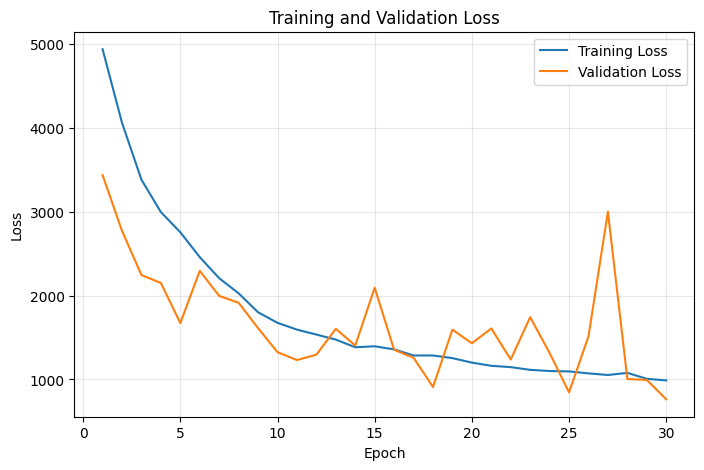

In [7]:
# Plotta la curva di training loss dal CSV
training_csv_path = checkpoint_dir / 'training_result.csv'
plot_training_validation_loss_from_csv(training_csv_path)

## 6. Test e Valutazione su sample del Test Set (solo rotazione)

In [8]:
NAME = "pose_rgb_endtoend"
checkpoint_dir = Config.CHECKPOINT_DIR / "pose" / NAME
checkpoint_weights_dir = checkpoint_dir / "weights"
best_path = checkpoint_weights_dir / "best.pt"
last_path = checkpoint_weights_dir / "last.pt"

### 6.1 Visualizza predizione su batch immagini

✅ Modello pose_rgb_endtoend caricato e in modalità eval!
Batch casuale: estrazione batch random dal dataset di test
Indice di inizio batch casuale: 12357
Numero di sample estratti: 64
Chiavi batch: ['rgb_crop', 'rgb', 'quaternion', 'translation', 'cam_K', 'bbox', 'folder_id', 'sample_id', 'obj_id', 'depth_path', 'rgb_path', 'info_path']

Conversione quaternioni in matrici di rotazione
Carico odelli 3D degli oggetti in memoria. 
Questi vengono usati per calcolare la metrica ADD.
✅ Loaded model 01: 5841 points
✅ Loaded model 02: 38325 points
✅ Loaded model 04: 18995 points
✅ Loaded model 05: 22831 points
✅ Loaded model 06: 15736 points
✅ Loaded model 08: 12655 points
✅ Loaded model 09: 7912 points
✅ Loaded model 10: 18473 points
✅ Loaded model 11: 7479 points
✅ Loaded model 12: 15972 points
✅ Loaded model 13: 18216 points
✅ Loaded model 14: 27435 points
✅ Loaded model 15: 16559 points

Calcolo metrica ADD full pose
Test completato su 64 sample

📊 ADD medio sul batch:
   Mean ADD: 72.0589

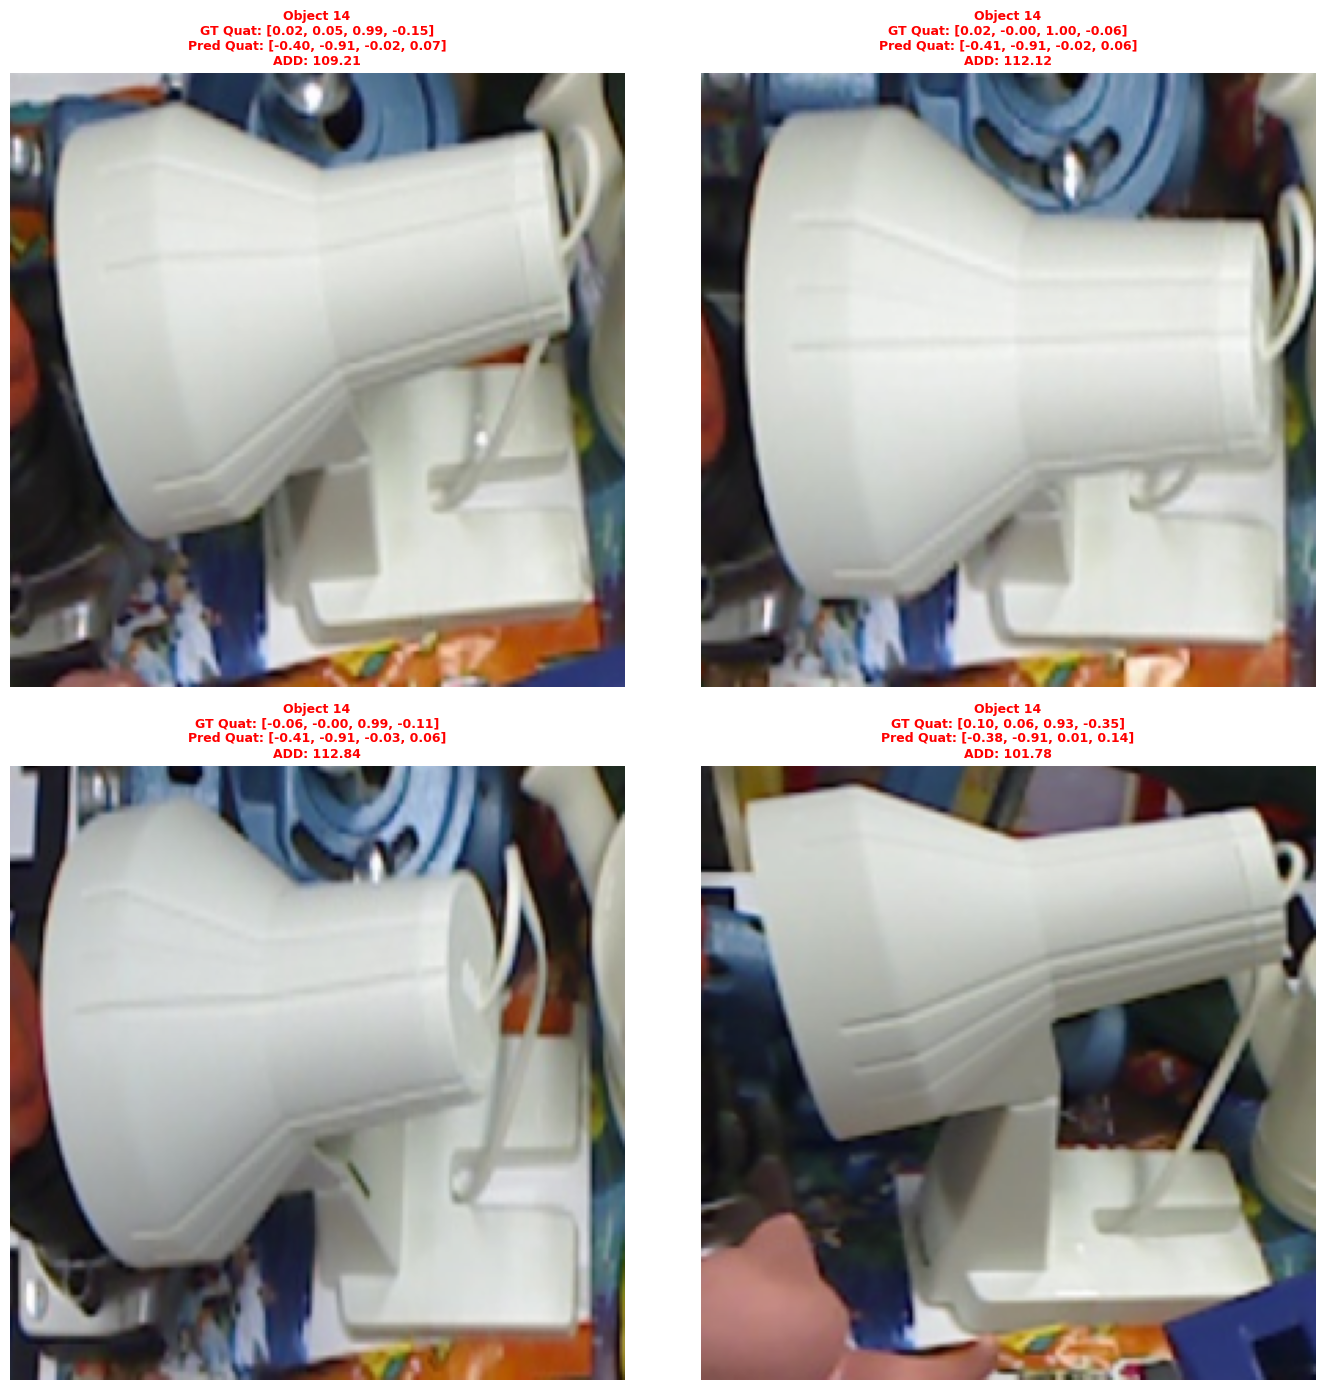

In [9]:
# Carica il modello trained (se necessario)
try:
    model.load_state_dict(torch.load(best_path, map_location=Config.DEVICE))
    model.eval()
    print(f"✅ Modello {NAME} caricato e in modalità eval!")
except Exception as e:
    print(f"⚠️  Modello non trovato o già caricato. Errore: {e}")
    raise SystemExit("Modello non trovato")

# Estrai un batch casuale direttamente dal dataset di test
print("Batch casuale: estrazione batch random dal dataset di test")
random_start = random.randint(0, len(test_loader.dataset) - test_loader.batch_size)
print(f"Indice di inizio batch casuale: {random_start}")
indices = list(range(random_start, random_start + test_loader.batch_size)) # lista indici selezionati
samples = [test_loader.dataset[i] for i in indices]
print(f"Numero di sample estratti: {len(samples)}")

# Collate i sample come fa il DataLoader
batch = {}
for k in samples[0]:
    values = [sample[k] for sample in samples]
    if isinstance(values[0], torch.Tensor):
        batch[k] = torch.stack(values)
    else:
        batch[k] = values
print(f"Chiavi batch: {list(batch.keys())}")
test_batch = batch

images = test_batch['rgb_crop'].to(Config.DEVICE)
gt_quaternions = test_batch['quaternion'].to(Config.DEVICE)
gt_translations = test_batch['translation'].to(Config.DEVICE) if 'translation' in test_batch else None
obj_ids = test_batch['obj_id']

with torch.no_grad():
    pred_quaternions, pred_translations = model(images)

# Conversione quaternioni in matrici di rotazione
print("\nConversione quaternioni in matrici di rotazione")
pred_R = quaternion_to_rotation_matrix_batch(pred_quaternions)
gt_R = quaternion_to_rotation_matrix_batch(gt_quaternions)

# Calcola la metrica ADD full pose (usa utils.metrics)
models_dict = load_all_models()
models_info = load_models_info(Config.LINEMOD_ROOT / "models" / "models_info.yml")

print("\nCalcolo metrica ADD full pose")
results = compute_add_batch_full_pose(pred_R, pred_translations.cpu().numpy(), gt_R, gt_translations.cpu().numpy(), obj_ids.cpu().numpy() if hasattr(obj_ids, 'cpu') else obj_ids, models_dict, models_info)

rot_trans_errors = results.get('add_values', None)
print(f"Test completato su {len(images)} sample")
print(f"\n📊 ADD medio sul batch:")
print(f"   Mean ADD: {np.mean(rot_trans_errors):.4f} ± {np.std(rot_trans_errors):.4f}")

# Visualizza 4 sample con errore di rotazione+traslazione
show_pose_samples_with_add(images, gt_quaternions, pred_quaternions, obj_ids, rot_trans_errors)

### 6.2 Statistiche su intero Test set

In [10]:
# Valutazione deep-only (senza pinhole): salva risultati in CSV
run_deep_pose_pipeline(model, test_loader, name=NAME)

✅ Modello pose_rgb_endtoend caricato!
Carico odelli 3D degli oggetti in memoria. 
Questi vengono usati per calcolare la metrica ADD.
✅ Loaded model 01: 5841 points
✅ Loaded model 02: 38325 points
✅ Loaded model 04: 18995 points
✅ Loaded model 05: 22831 points
✅ Loaded model 06: 15736 points
✅ Loaded model 08: 12655 points
✅ Loaded model 09: 7912 points
✅ Loaded model 10: 18473 points
✅ Loaded model 11: 7479 points
✅ Loaded model 12: 15972 points
✅ Loaded model 13: 18216 points
✅ Loaded model 14: 27435 points
✅ Loaded model 15: 16559 points


Validazione GT crops (end-to-end): 100%|██████████| 210/210 [01:58<00:00,  1.77it/s]


Concatenazione batch...
Calcolo metriche: ADD full pose (end-to-end)
✅ Risultati di validazione salvati in /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/validation_result.csv
✅ Risultati salvati in /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/validation_result.csv


### 6.3 Tabella: Media ADD e Accuracy per Classe

La tabella seguente riporta la media dell'errore ADD e l'accuracy (percentuale di pose corrette) per ciascuna classe (oggetto) del dataset LineMOD.

In [11]:
# Carica risultati validazione dal CSV usando utils/validation.py
from utils.validation import load_validation_results
NAME = "pose_rgb_endtoend"
checkpoint_dir = Config.CHECKPOINT_DIR / "pose" / NAME
val_csv_path = checkpoint_dir / 'validation_result.csv'
if val_csv_path.exists():
    results_full_pose, _ = load_validation_results(val_csv_path)
    print(f"✅ Risultati caricati da {val_csv_path}")
else:
    results_full_pose = globals().get('results_full_pose', None)
    if results_full_pose is None:
        print("⚠️  Devi prima calcolare la metrica ADD full pose su tutto il test set e salvare i risultati in 'results_full_pose'.")

✅ Risultati caricati da /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/validation_result.csv


In [12]:
# Tabella: Performance rotazione + traslazione (ADD full pose) usando utils/validation.py
from utils.validation import calc_add_accuracy_per_class
if results_full_pose is not None:
    data, global_add, global_acc = calc_add_accuracy_per_class(results_full_pose, Config.LINEMOD_OBJECTS)
    df = pd.DataFrame(data)
    display(df)
    print("\nMedia globale ADD (full pose):", f"{global_add:.2f}")
    print("Accuracy globale (full pose) (%):", f"{global_acc:.1f}")

,Classe,Media ADD,Accuracy (%)
0,01 - ape,33.81,4.1
1,02 - benchvise,68.65,7.2
2,04 - camera,71.44,5.3
3,05 - can,62.52,5.2
4,06 - cat,46.71,6.6
5,08 - driller,66.87,9.2
6,09 - duck,40.68,5.5
7,10 - eggbox,8.23,100.0
8,11 - glue,9.24,99.1
9,12 - holepuncher,54.39,6.5



Media globale ADD (full pose): 52.84
Accuracy globale (full pose) (%): 21.3


### 6.4 Grafico: Media ADD per Classe

Il grafico seguente mostra la media dell'errore ADD per ciascuna classe, per un confronto visivo immediato delle performance del modello sui diversi oggetti.

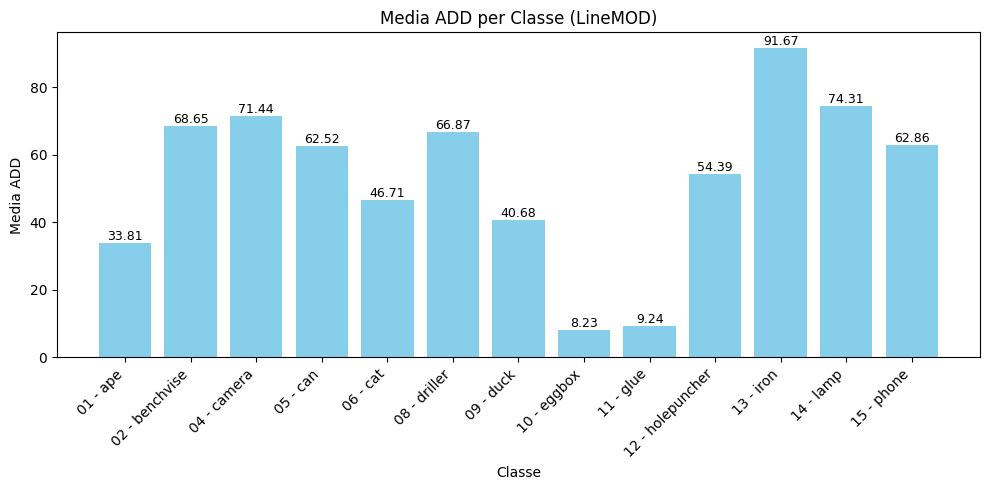

In [13]:
# Grafico a barre delle medie ADD per classe (full pose)
results_full_pose = globals().get('results_full_pose', None)
if results_full_pose is None:
    print("⚠️  Devi prima calcolare la metrica ADD full pose su tutto il test set e salvare i risultati in 'results_full_pose'.")
else:
    plot_add_per_class(results_full_pose, Config.LINEMOD_OBJECTS)